In [1]:
from utils import *
from img_utils import *

2024-02-13 14:30:47.673760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 14:30:47.673812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 14:30:47.674899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 14:30:47.681134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 14:30:48.702431: W tensorflow/compiler/tf2

# Loading Data 

In [2]:
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)
houses_df = houses_df[(houses_df['postal_code'] >= 1000) & (houses_df['postal_code'] <= 2920)]
houses_df = houses_df[houses_df['type'] == 'ejerlejlighed']
print("Number of datapoints of type 'Ejerlejlighed': ", len(houses_df))
display(houses_df)

[ WARN:0@12.262] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@14.528] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity


Number of datapoints of type 'Ejerlejlighed':  362


# Setting up splits

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

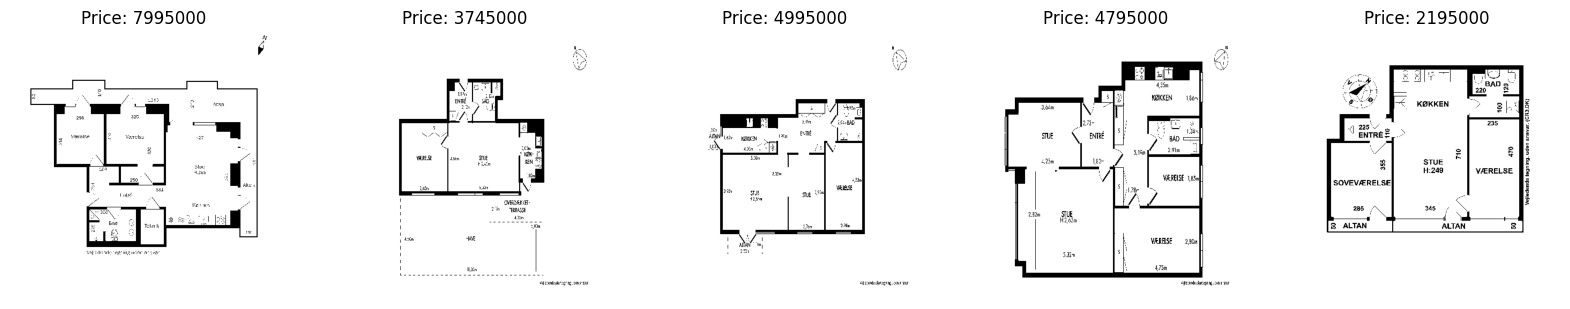

In [ ]:
target_width = 500
target_height = 500

resize = True
gray_scale = False
threshhold = True

train_images_RGB = preprocess_images(train_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)
validation_images_RGB = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)
test_images_RGB = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)

train_prices = train_df['price']
validation_prices = valid_df['price']
test_prices = test_df['price']

#Plot the first 5 images and their prices 
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(train_images_RGB[i])
    ax[i].set_title(f"Price: {train_prices.iloc[i]}")
    ax[i].axis('off')
plt.show()


# Pre-trained VGG16

In [ ]:
import tensorflow as tf
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Set the GPU to be used
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available")

1 Physical GPUs, 1 Logical GPU


2024-02-13 14:29:56.251063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 14:29:56.273784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 14:29:56.273893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 14:29:56.277726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 14:29:56.277829: I external/local_xla/xla/stream_executor

## Model Fitting

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model (without including top layers)
input_shape = train_images_RGB[0].shape 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new top layers for regression
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(1, activation="linear")
])

In [ ]:
# Compile the model
#0.0001
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 15, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 512)               58982912  
                                                                 


 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73829185 (281.64 MB)
Trainable params: 59114497 (225.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping callback
history = model.fit(train_images_RGB, train_df["price"], validation_data=(validation_images_RGB, valid_df["price"]), epochs=50, callbacks=[early_stopping])

Epoch 1/50


2024-02-13 14:29:58.422793: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-13 14:29:58.612816: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-13 14:30:00.880408: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-13 14:30:00.880454: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-02-13 14:30:06.861730: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allo

7/8 [=========================>....] - ETA: 0s - loss: 3679946.2500

In [ ]:
model.evaluate(test_images_RGB, test_df["price"])

# Make predictions
predictions = model.predict(test_images_RGB)

3/3 [==============================] - 1s 480ms/step


## Model Evaluation

R2 score: 0.04
Mean Absolute Error: 2330163.61
Mean Squared Error: 11019860029937.20


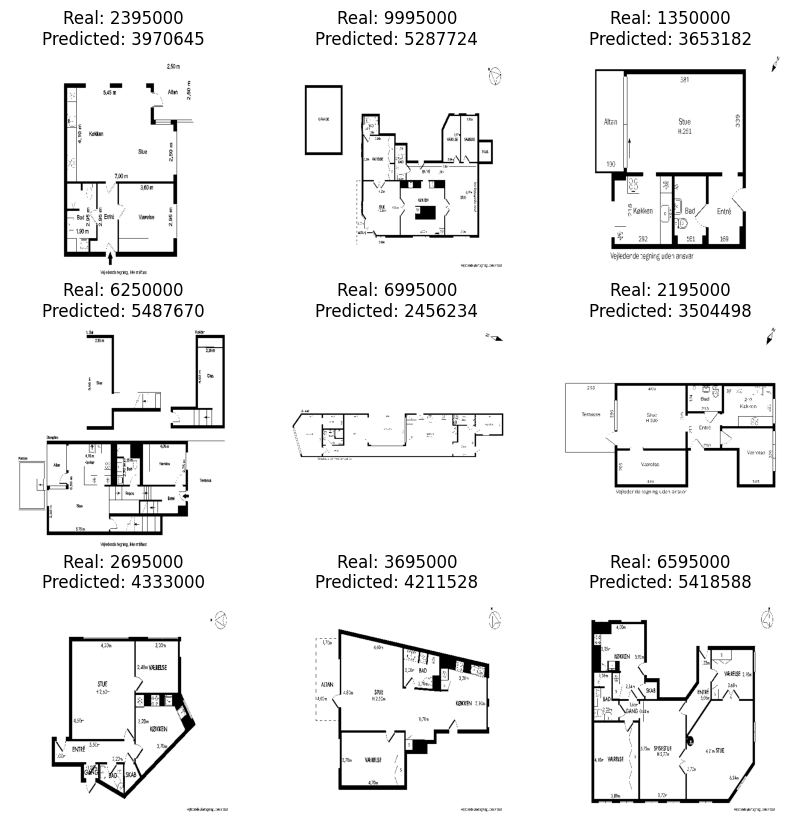

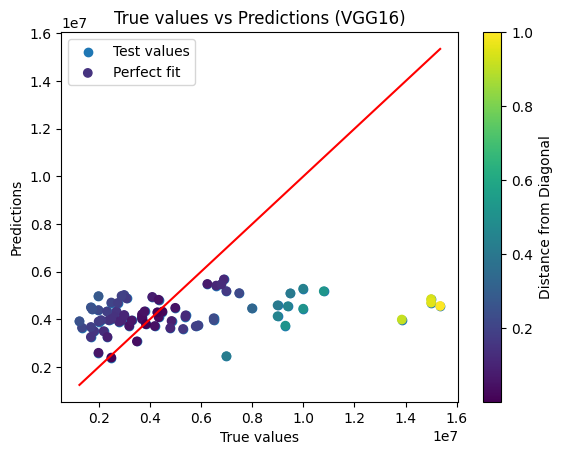

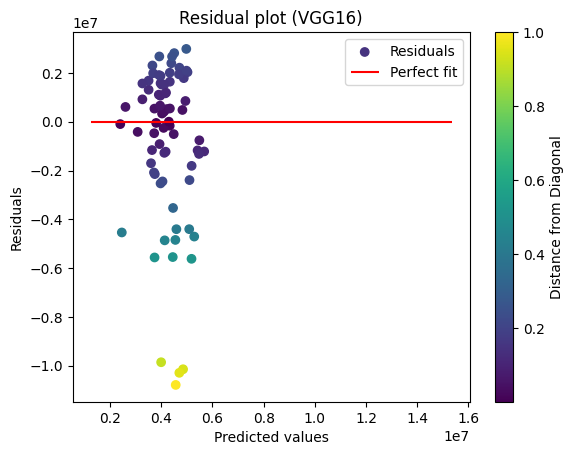

In [ ]:
real_prices = test_df['price'].values
predicted_prices = predictions.flatten()

# Print the R2 score, MAE and MSE
print(f"R2 score: {r2_score(real_prices, predicted_prices):.2f}")
print(f"Mean Absolute Error: {mae(real_prices, predicted_prices):.2f}")
print(f"Mean Squared Error: {mse(real_prices, predicted_prices):.2f}")

# Plot the predictions
plt.figure(figsize=(10, 10))
for i, (image, label, prediction) in enumerate(zip(test_images_RGB[0:9], test_df["price"][0:9], predictions[0:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Real: {label}\nPredicted: {prediction[0]:.0f}")
    plt.axis("off")
plt.show()

# Plot the predictions vs real prices
plot_regression_results('VGG16', real_prices, predicted_prices)